# Access EAP IIIF manifest images through the IIIF image API

This tutorial is heavily inspired by the wiki article by Adam Farquhar, found [here](https://wiki.bl.uk:8443/display/DSSP/Accessing+EAP+Images+on-line) (must be on the BL network!)

In [7]:
import requests, json, re, os
import numpy as np
from tqdm import tqdm

Set this argument to true if you want to download the EAP images requested, otherwise we will just print a list of files that could be potentally downloaded

Define a function that retrieves and downloads (if `downloadImages` is `True`, defaults to `False`) an entire EAP manifest. 

In [8]:
def getManifestImages(manReq,downloadImages=False,resize='full',firstImg=0,lastImg=-1):
    manifestURL='https://eap.bl.uk/archive-file/'+manReq+'/manifest'
    mjdata=requests.get(manifestURL)
    binary=mjdata.content
    output=json.loads(binary)
    
    pImgList=[]
    imglist=[]
    
        
    regex="([0-9]+\.jp2)"
    p = re.compile(regex)
    
    
    
    for sequence in output['sequences']:
        for canvas in sequence['canvases']:
            for image in canvas['images']:
                imagetarget=image['resource']['@id']
                pImgList.append(imagetarget)


    finalImg=int(p.search(pImgList[-1]).group(1).split('.',1)[0])           
    if lastImg == -1:
        lastImg=finalImg
        
    try:
        assert finalImg >= lastImg
    except AssertionError:
        print("lastImg: {} greater than filename of last image in manifest: {}".format(lastImg,finalImg))
        return -1
        
    for image in pImgList:
        matchNums=int(p.search(image).group(1).split('.',1)[0])
        if (matchNums >= firstImg) and (matchNums<= lastImg): # need to catch cases where lastImage = -1 
            imglist.append(image)
            

    print("original image list:")
    for item in imglist:
        print(item)

    if(resize!='full'):	
        imglist=[img.replace('/full/full','/full/'+resize+',') for img in imglist]

        print("Edited image list:")
        for item in imglist:
            print(item)


    imgnames=[]
    for img in imglist:
        imgnames.append(re.search('(?<=\/EAP...\/)\w+\/.+\.jp2',img).group(0))

    imgnames=[name.replace('.jp2','.jpg') for name in imgnames]
    imgnames=[name.replace('/','_') for name in imgnames]

    if len(imgnames) != len(imglist):
        raise ValueError("list of images and list of images names must be same length")

    

    manifestDirName=re.search('(?<=\/EAP...\/)\w+\/',img).group(0)
    if not os.path.exists('./'+manifestDirName) and downloadImages:
        os.makedirs(manifestDirName)

    if(downloadImages):
        print("Downloading images")

        for i in tqdm(range(0,len(imglist))):
            #print("Downloading {} from {}...".format(imgnames[i],imglist[i]))
            f=open(manifestDirName+'/'+imgnames[i],'wb')
            f.write(requests.get(imglist[i]).content)
            f.close()
            
    return imglist

## Append manifests you want all of the images from to the following list:	  
```manifestsRequested=['EAP613-1-2','EAP613-2-2-1'] ```  
*n.b. requests made previously will not be processed again if the following command is used*  

Pass integers to `firstImg` and `lastImg` to denote the first and last images in a manifest that you would like to access. All manifests contain images numbered `1.jp2` to `n.jp2`, where `n` is the number of images in the manifest. This functionality now uses regular expressions to avoid indexing into the list of images returned. This helped avoid an issue in cases where the filename `n.jp2` had values of `n` greater than the number of images returned.

**The default behaviour** is to return all images in a manifest. If you want this, then you can omit the `firstImg` and `lastImg` arguments entirely!

The list of urls requested is returned as a list.

### Try it yourself!

In [14]:
manifestImages=[]
manifestsRequested=['EAP139-1-1']
for manifest in manifestsRequested:
    manifestTestDirName=manifest.replace('-','_')
    if not os.path.exists(manifestTestDirName):
        manifestImages=getManifestImages(manifest,downloadImages=True,firstImg=1,lastImg=10)



  0%|          | 0/10 [00:00<?, ?it/s]

original image list:
https://images.eap.bl.uk/EAP139/EAP139_1_1/1.jp2/full/full/0/default.jpg
https://images.eap.bl.uk/EAP139/EAP139_1_1/2.jp2/full/full/0/default.jpg
https://images.eap.bl.uk/EAP139/EAP139_1_1/3.jp2/full/full/0/default.jpg
https://images.eap.bl.uk/EAP139/EAP139_1_1/4.jp2/full/full/0/default.jpg
https://images.eap.bl.uk/EAP139/EAP139_1_1/5.jp2/full/full/0/default.jpg
https://images.eap.bl.uk/EAP139/EAP139_1_1/6.jp2/full/full/0/default.jpg
https://images.eap.bl.uk/EAP139/EAP139_1_1/7.jp2/full/full/0/default.jpg
https://images.eap.bl.uk/EAP139/EAP139_1_1/8.jp2/full/full/0/default.jpg
https://images.eap.bl.uk/EAP139/EAP139_1_1/9.jp2/full/full/0/default.jpg
https://images.eap.bl.uk/EAP139/EAP139_1_1/10.jp2/full/full/0/default.jpg


100%|██████████| 10/10 [00:04<00:00,  2.10it/s]


### Viewing a random image from your chosen images:

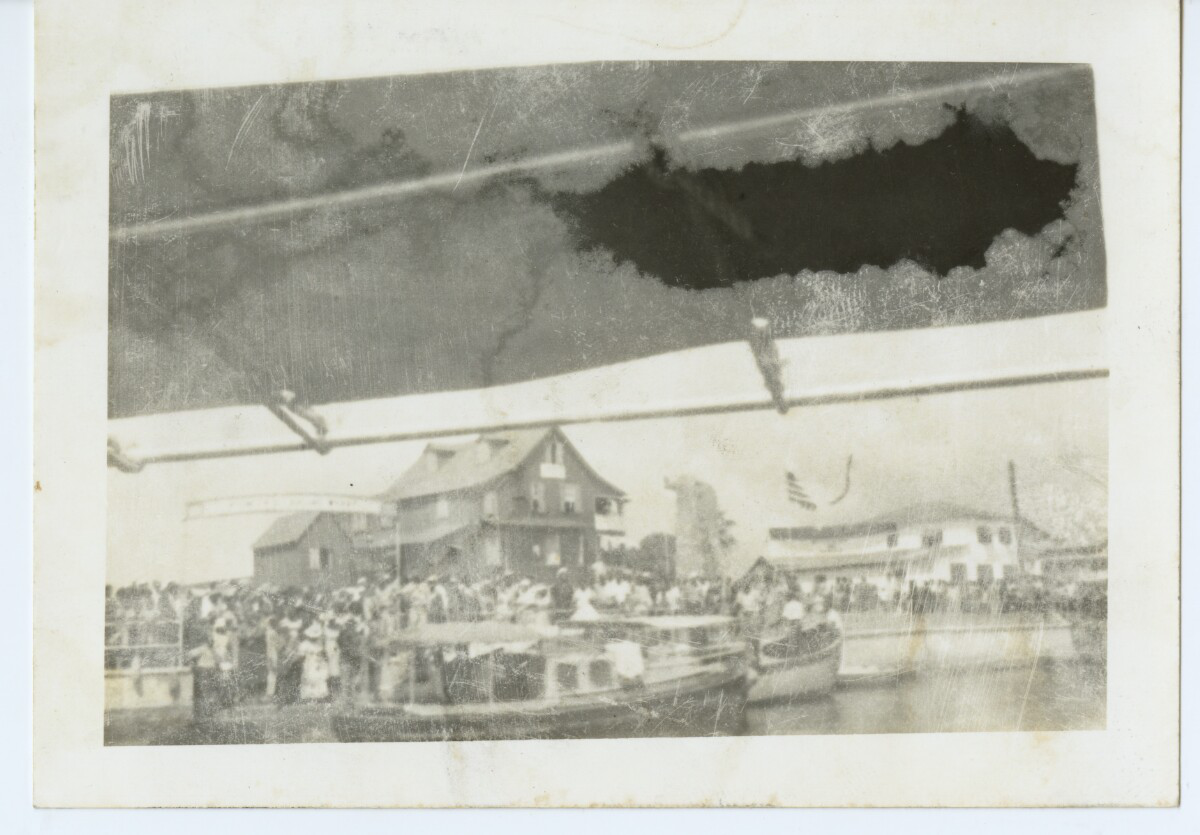

In [13]:
from PIL import Image
import requests
from io import BytesIO

np.random.seed=42
randomImg=np.random.choice(manifestImages)

response = requests.get(randomImg)
Image.open(BytesIO(response.content))


